# Churn Prediction - Exploratory Data Analysis
The goal of this study is to predict "churn", so when customers leave their telecom provider. The dataset containing 100 features describing network usage, company revenue and demographic features per user. It is not given what kind of incentives will be offered to the users identified as potential churners. 

EDA strives to identify differences between the populations of churners and non-churners which could be used as predictive features. In the first part features are analysed manually, following feature descriptions in notes.txt, and in the second part KMeans algorithm is used to cluster the dataset and identify differences between the clusters. 

Author: Daniel Grzebyk

Date: August 7th, 2022

In [16]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2

sys.path.append("C:\\Users\\danie\\PycharmProjects\\data_analysis\\utils\\")
from classification_utils import chi_test, find_boolean_features
from functions import display_factorial_planes, display_parallel_coordinates_centroids

## Loading the data

In [2]:
df = pd.read_csv("../data/telecom/data.csv")
var_df = pd.read_csv("../data/telecom/variables-definition.csv")

## Exploratory Data Analysis (EDA)
Research Question: Why customers leave the company?

Hypothesis to be verified:
- the services are too expensive - if yes, then lower income households would leave more frequently, as they are more price-sensitive
- the services are not required - if yes, few calls, low data usage, etc.
- low quality of service - many calls failed due to network issues
- geography: maybe in some geographical areas (lower network coverage or income)
- are household with children more loyal customers?

Relevant Observations:
- Data Structure: every row is a customer / household
- Problem: binary classification problem: predict whether a customer will stay with the telecom company or leave
- Label: churn - the customer will leave [yes / no]

Interesting features
- Failed calls might indicate issues with the quality of service. What % of all calls fails, and how does it influence customer loyalty?
- Time spent calling customer service, happy customers rarely call.

Features not relevant for predicting churn:
- Number and minutes of unanswered and received calls
- Whether calls are wireless or not
- Network traffic, whether call is peak or off-peak
- The number of call participants
- Whether calls are incoming or outbound
- Distinction between voice and data calls

### Loyalty
The distribution is right-skewed, peak around the 12th month might indicate a past sale or a marketing campaign. The longest staying customer is with the company for 5 years. Despite some small fluctuations in the left part of the distribution, churners and non-churners seem to stay with the company for similar time.

<AxesSubplot:xlabel='months', ylabel='Count'>

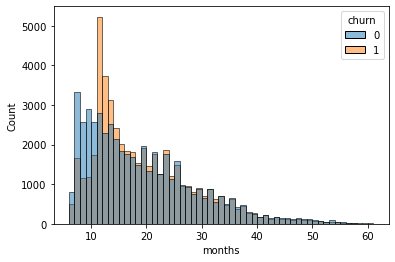

In [3]:
sns.histplot(data=df, x='months', hue='churn', binwidth=1)

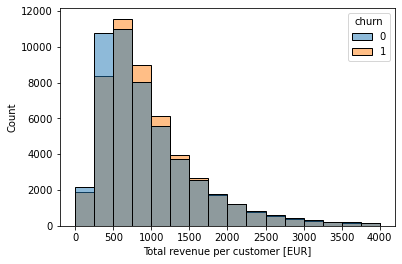

In [4]:
sns.histplot(data=df, x='totrev', hue='churn', binrange=(0, 4000), binwidth=250)
plt.xlabel("Total revenue per customer [EUR]")
plt.show()

### Company Revenue
As customer requirements are covered by multiple products, in order to check which customers significantly changed their consumption it is the easiest to look at the revenue. It can be seen that around 5% of all customers reduced their spending by at least 50% with respect to the 3 month mean. These customers might be the potential leavers.

After identifying who the potential leavers might be, it will be checked what % of revenue they bring to the company. E.g. suddent outflow of high-revenue clients could be a source of a major concern.

In [5]:
rapid_reduction_rate = round(len(df['change_rev'].loc[df['change_rev'] < -50]) / len(df), 2)
rapid_reduction_rate

0.05

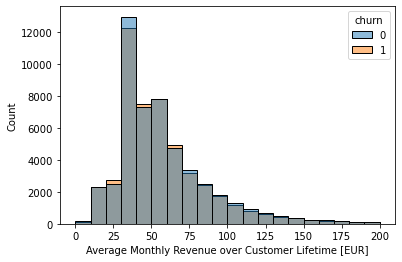

In [6]:
sns.histplot(data=df, x='avgrev', hue='churn', binrange=(0, 200), binwidth=10)
plt.xlabel("Average Monthly Revenue over Customer Lifetime [EUR]")
plt.show()

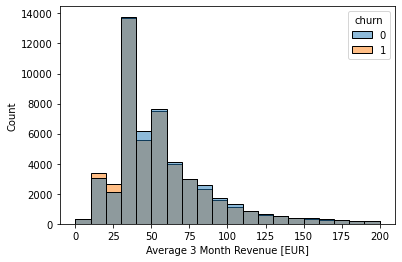

In [7]:
sns.histplot(data=df, x='avg3rev', hue='churn', binrange=(0, 200), binwidth=10)
plt.xlabel("Average 3 Month Revenue [EUR]")
plt.show()

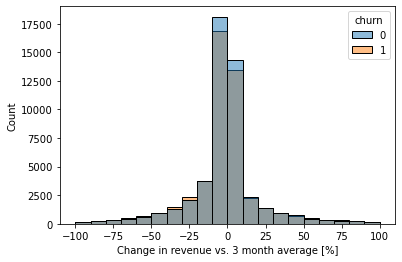

In [8]:
sns.histplot(data=df, x='change_rev', binrange=(-100, 100), binwidth=10, hue='churn')
plt.xlabel("Change in revenue vs. 3 month average [%]")
plt.show()

Customers who use more than they declared in their plan often bear additional costs. Are these costs the reason why they change the service provider? Probably not, as they are usually less than 10% of the overall costs.

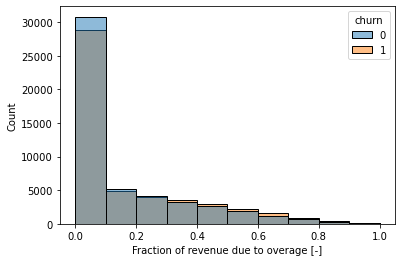

In [9]:
df['overrev_ratio'] = df['ovrrev_Mean'] / df['rev_Mean']
sns.histplot(x='overrev_ratio', data=df, binrange=(0, 1), binwidth=0.1, hue='churn')
plt.xlabel("Fraction of revenue due to overage [-]")
plt.show()
del df['overrev_ratio']

### Demand
Clearly, there are very few customers who pay for the service and not use it. Therefore, rapid drop in demand might be correlated with churn.

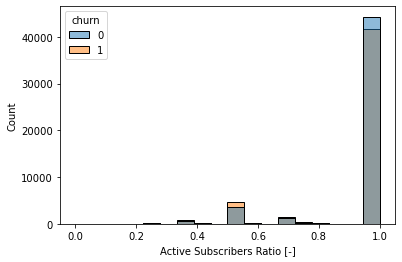

In [10]:
df['actsubs_ratio'] = df['actvsubs'] / df['uniqsubs']
sns.histplot(data=df, x='actsubs_ratio', hue='churn')
plt.xlabel("Active Subscribers Ratio [-]")
del df['actsubs_ratio']

Text(0.5, 0, 'Minutes of Usage - 3 Month Average [-]')

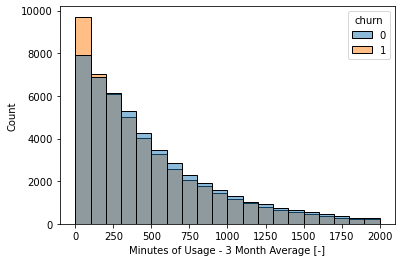

In [11]:
sns.histplot(data=df, x='avg3mou', hue='churn', binrange=(0, 2000), binwidth=100)
plt.xlabel("Minutes of Usage - 3 Month Average [-]")

### Customers social status
Client income is a categorical variable, but no information about the brackets for each class were provided. It is assumed that income will be the most influencial of all status-related features including also: size of dwelling, credit card information, number of cars, etc. Strong correlations are expected between these features, and perhaps some of them could be removed. 

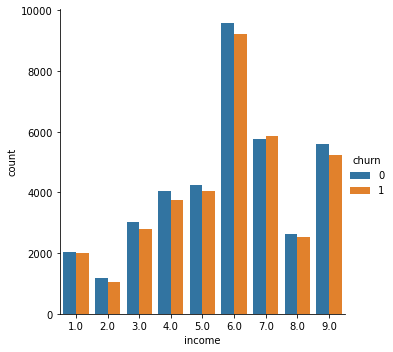

In [12]:
sns.catplot(x="income", hue="churn", data=df, kind="count")

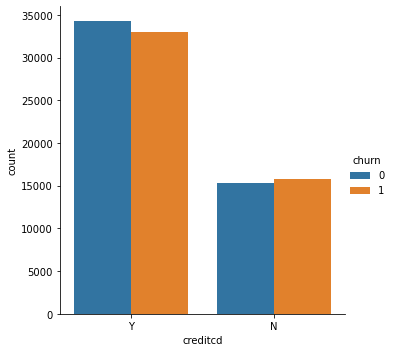

In [13]:
sns.catplot(x="creditcd", hue="churn", data=df, kind="count")

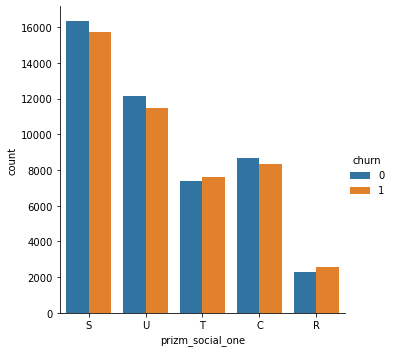

In [14]:
sns.catplot(x="prizm_social_one", hue="churn", data=df, kind="count")

Chi test is used to check whether there is correlation between income and other features related to social status. As expected, all features in this category are correlated which means they do not introduce new information to the dataset and could be removed. This is not done yet, as these features could provide differentiation between churners and non-churners in the clustering results.  

In [15]:
maybe_dependent_cols = ['crclscod', 'asl_flag', 'prizm_social_one', 'ownrent', 'lor', 'dwlltype', 'dwllsize', 'numbcars', 
                        'HHstatin', 'forgntvl', 'creditcd']
correlated_features, uncorrelated_features, results_dict = chi_test(df, maybe_dependent_cols, df['income'])
df.drop(columns=correlated_features, inplace=True)

In [16]:
correlated_features

['crclscod',
 'asl_flag',
 'prizm_social_one',
 'ownrent',
 'lor',
 'dwlltype',
 'dwllsize',
 'numbcars',
 'HHstatin',
 'forgntvl',
 'creditcd']

In [17]:
uncorrelated_features

[]

### Household information
How many households have children, and are households with children more loyal customers? The initial hypothesis is the parents of young children are too busy to make changes in telecom providers, but this tendency is expected to disappear as children are older.

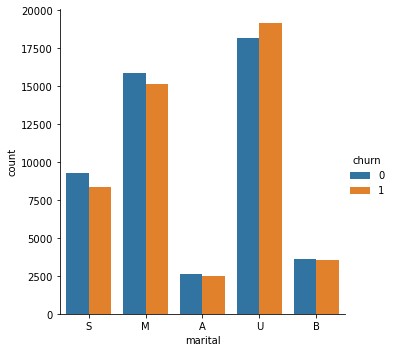

In [18]:
sns.catplot(x="marital", hue="churn", data=df, kind="count")

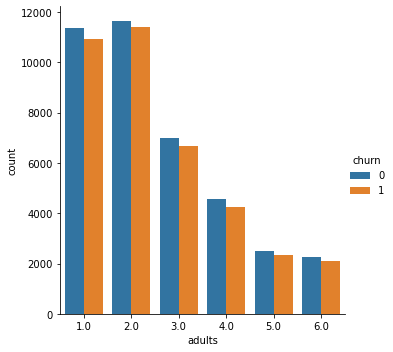

In [19]:
sns.catplot(x="adults", hue="churn", data=df, kind="count")

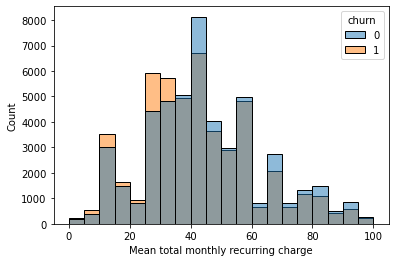

In [20]:
sns.histplot(data=df, x='totmrc_Mean', binrange=(0, 100), binwidth=5, hue='churn')
plt.xlabel("Mean total monthly recurring charge")
plt.show()

### Quality of service
Median time of a call with customer service is 2 min which might mean the issues are resolved relatively quickly.

In [21]:
(df['ccrndmou_Mean'] / df['custcare_Mean']).median()

2.000000003

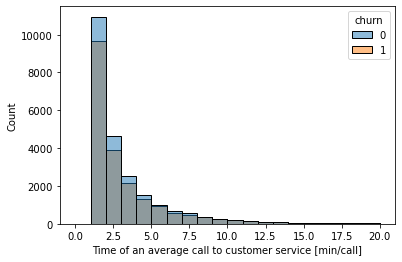

In [22]:
df['custcall_time_Mean'] = df['ccrndmou_Mean'] / df['custcare_Mean']

sns.histplot(data=df, x='custcall_time_Mean', hue='churn', binrange=(0, 20), binwidth=1)
plt.xlabel("Time of an average call to customer service [min/call]")
plt.show()
del df['custcall_time_Mean']

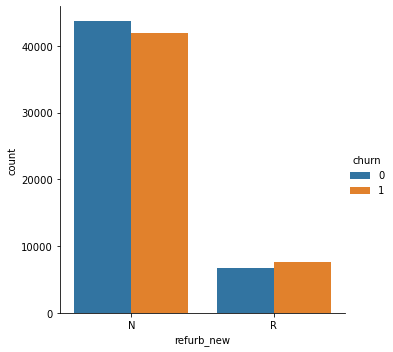

In [23]:
sns.catplot(x="refurb_new", hue="churn", data=df, kind="count")

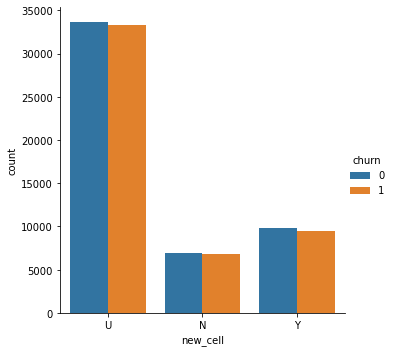

In [24]:
sns.catplot(x="new_cell", hue="churn", data=df, kind="count")

Clearly, churners use cheaper phones and less frequently have dualband which might influence their quality of service, e.g. download/upload speeds.

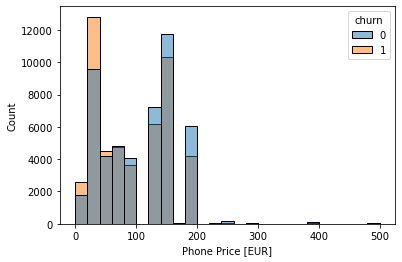

In [25]:
sns.histplot(data=df, x="hnd_price", hue="churn", binwidth=20, binrange=(0, 500))
plt.xlabel("Phone Price [EUR]")
plt.show()

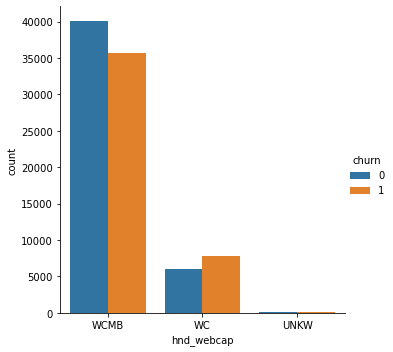

In [26]:
sns.catplot(data=df, x="hnd_webcap", hue="churn", kind="count")

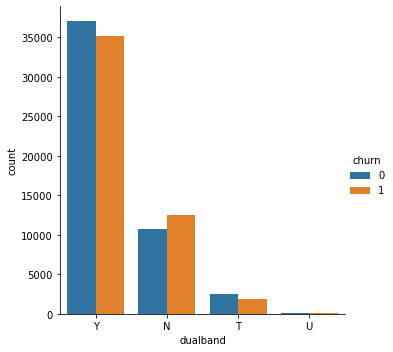

In [27]:
sns.catplot(data=df, x="dualband", hue="churn", kind="count")

High percentage of failed calls or old equipment could indicate low quality of service and influence customer churn. Based on the figure below, the distribution failed calls is similar for both groups, but the age of the equipment is clearly higher for the churners.

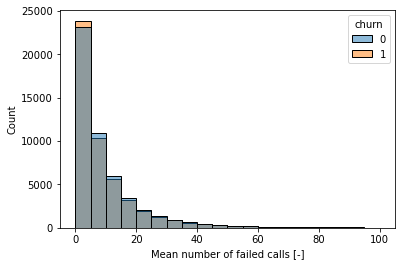

In [28]:
df['failed_calls'] = df['drop_vce_Mean'] + df['drop_dat_Mean'] + df['blck_vce_Mean'] + df['blck_dat_Mean']
sns.histplot(data=df, x='failed_calls', hue='churn', binrange=(0, 100), binwidth=5)
plt.xlabel("Mean number of failed calls [-]")
plt.show()

Older equipment does not suffer from larger number of failed calls.

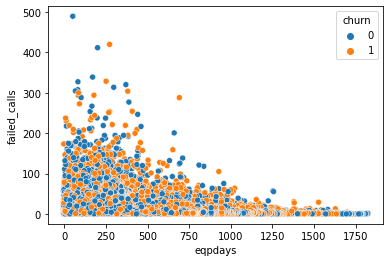

In [29]:
sns.scatterplot(data=df, x='eqpdays', y='failed_calls', hue='churn')
del df['failed_calls']

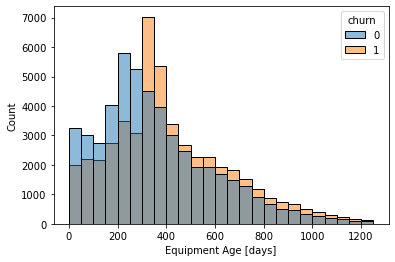

In [30]:
sns.histplot(data=df, x='eqpdays', hue='churn', binrange=(0, 1250), binwidth=50)
plt.xlabel("Equipment Age [days]")
plt.show()

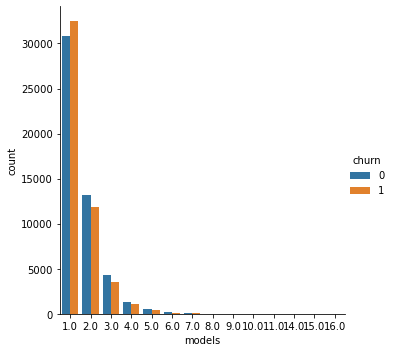

In [31]:
sns.catplot(data=df, x='models', hue='churn', kind='count') # , binrange=(0, 20), binwidth=1

### Other
Churn is more or less equally distributed across all areas of operation. Non-uniform distribution could undicate e.g. new strong competition. 

<AxesSubplot:>

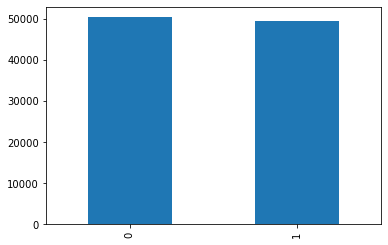

In [32]:
df['churn'].value_counts().plot(kind='bar')

## Chi test
Chi test, called also _test for independence_, allows to identify the categorical features which are not correlated with the label and therefore have no predictive power. For the test the significance level of 0.05 was used. 

In [33]:
cat_features = df.select_dtypes(include='object').columns

my_x = df[cat_features].dropna().copy()
my_y = df['churn'].loc[my_x.index]

one_hot = OneHotEncoder(sparse=False)  # handle_unknown='ignore'
my_x_enc = one_hot.fit_transform(my_x)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(my_x_enc, my_y)

X_train_chi = chi2_selector.transform(my_x_enc)

In [34]:
feature_names = one_hot.get_feature_names(cat_features)

chi_df = pd.DataFrame({"feature": feature_names, "score": chi2_selector.scores_, "p_value": chi2_selector.pvalues_})
chi_df.loc[chi_df['p_value'] < 0.05].sort_values(by='p_value').head(5)

C:\Users\danie\anaconda3\envs\data_analysis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,score,p_value
29,hnd_webcap_WC,311.278190,1.150221e-69
54,ethnic_Z,122.827290,1.521315e-28
48,ethnic_O,81.442268,1.804569e-19
27,refurb_new_R,71.981433,2.172317e-17
16,area_NORTHWEST/ROCKY MOUNTAIN AREA,64.364388,1.034105e-15


In [35]:
beginnings = chi_df['feature'].apply(lambda x: x.split("_")[:-1])
np.unique(beginnings.values)

array([list(['area']), list(['dualband']), list(['ethnic']),
       list(['hnd', 'webcap']), list(['infobase']), list(['kid0', '2']),
       list(['kid11', '15']), list(['kid16', '17']), list(['kid3', '5']),
       list(['kid6', '10']), list(['marital']), list(['new', 'cell']),
       list(['refurb', 'new'])], dtype=object)

For low p-values the null hypothesis, stating that 'nothing unusual is going on', was rejected. The barplot below presents features which distributions differ for churners and non-churners. Therefore, they might contain information allowing to predict churn.

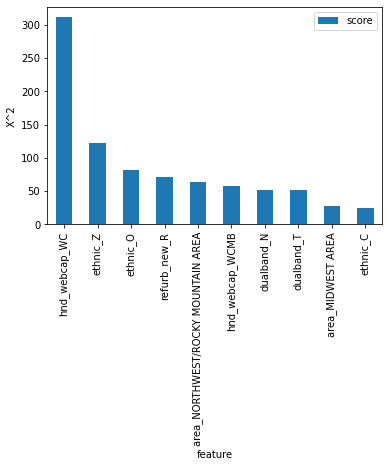

In [36]:
chi_df.nsmallest(10, columns=['p_value']).plot(x='feature', y='score', kind='bar')
plt.ylabel("X^2")
plt.show()

## Clustering
Clustering is used to gain further insight in the data without plotting a distribution for each feature manually. The optimal number of clusters was first selected using the elbow method. Then, due to lack of evident breakpoint ("elbow") in figure below, 2 clusters were selected to correspond to the number of classes (churn / no churn). 

In [37]:
num_features = df.select_dtypes(include='number').columns
X = df[num_features].copy()

X.isna().sum().sort_values(ascending=False).head()

income     25436
adults     23019
avg6mou     2839
avg6qty     2839
avg6rev     2839
dtype: int64

In [38]:
X.drop(columns=['Customer_ID', 'churn'], inplace=True) # 'income', 'adults', 
X.dropna(inplace=True)
print(X.shape)

(71574, 74)


In [39]:
%%time
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    distorsions.append(kmeans.inertia_)

CPU times: total: 4min 4s
Wall time: 36.1 s


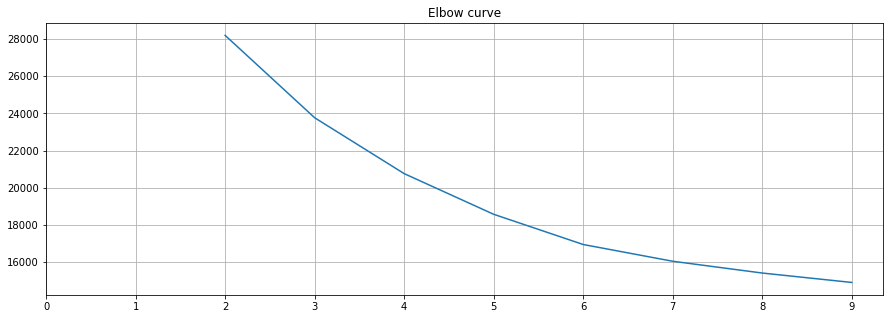

In [40]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.xticks(np.arange(0, 10, 1))
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [41]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)

KMeans(n_clusters=2)

Principal Component Analysis was used to visualise the clusters and confirm the optimal number of clusters. It implies using 3 centroids could be better to distinctly divide the data. However, results for 3 centroids were investigated and did not change the conclusions of this analysis. 

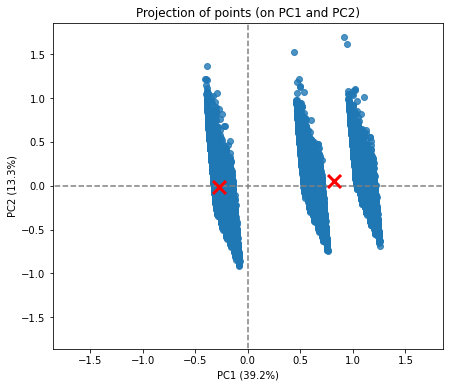

In [42]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(X_scaled)

# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = kmeans.labels_
X_reduceddf.head()

centres_reduced = pca.transform(kmeans.cluster_centers_)

display_factorial_planes(X_reduced, 2, pca, [(0,1)], alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

In [43]:
y = df['churn'].loc[X.index]
new_df = pd.DataFrame({"churn":y.values, "cluster":kmeans.labels_})
new_df['cluster'].value_counts()

0    53722
1    17852
Name: cluster, dtype: int64

Churn is more or less equally distributed across clusters which means these two groups do not have strong features making them clearly different. This is confirmed by the parallel coordinates plot for centroids where both lines overlap for the vast majority of time. Only _truck, rv, models_ features differentiate the clusters. Although the differences are small, top 10 features are used for further feature selection steps in _predicting_churn.ipynb_

In [44]:
new_df.groupby("cluster")['churn'].value_counts()

cluster  churn
0        0        27386
         1        26336
1        0         9041
         1         8811
Name: churn, dtype: int64

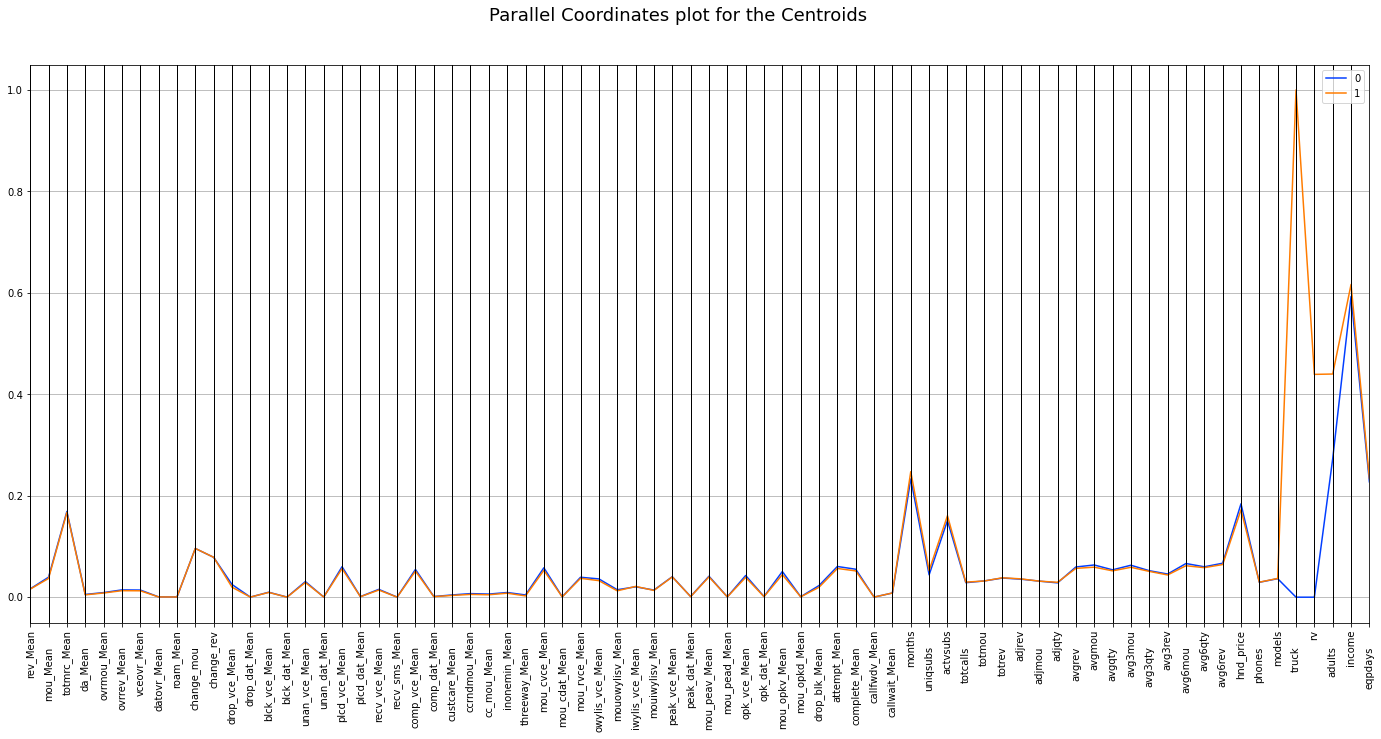

In [45]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 2)

In [58]:
mydf = centroids.diff().abs().dropna().T
mydf.rename(columns={1:"difference"}, inplace=True)
mydf.loc[mydf['difference'] > 0.006].sort_values(by='difference', ascending=False)  #.head()
# mydf.head()
mydf.sort_values(by='difference', ascending=False).head(10)

,difference
cluster,1.000000
truck,1.000000
rv,0.439222
adults,0.166874
income,0.023858
months,0.014269
hnd_price,0.011878
actvsubs,0.009650
uniqsubs,0.008436
eqpdays,0.006937


In [47]:
selected_features = list(mydf.loc[mydf['difference'] > 0.006].index)
selected_features

['mou_opkv_Mean',
 'months',
 'uniqsubs',
 'actvsubs',
 'hnd_price',
 'truck',
 'rv',
 'adults',
 'income',
 'eqpdays',
 'cluster']

## EDA Conclusions
Average churner uses cheaper and older handset than the customer who stay, many churners joined in the same month. Apart from these differences, both populations are similar. Demographic features such as number of kids and marital status, or status features, such as income and number of cars, are equally distributed between churners and non-churners. Therefore, they have no influence on the behaviour.

The aim of the Exploratory Data Analysis was to create a persona, model of an average churner, as well as distinguishing features helpful in predicting churn. This task was only partially successful, due to similarities in both populations. Predictive model was developed in _predicting_churn.ipynb_

## Appendix
#### Plotting unexplored features with some difference in parallel coordinates
Based on the differences in KMeans centroids several other features were visualized. All of them are dominated by churners in the first bin, but have very small differences in the following bins. The meaning behind these features can be found in _notes.txt_. Due to low significance they are not analysed in detail. 

<AxesSubplot:xlabel='mou_opkv_Mean', ylabel='Count'>

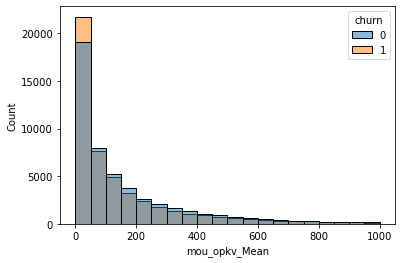

In [48]:
sns.histplot(data=df, x='mou_opkv_Mean', hue='churn', binrange=(0, 1000), binwidth=50)

<AxesSubplot:xlabel='avg3mou', ylabel='Count'>

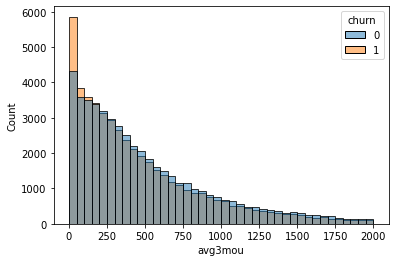

In [51]:
sns.histplot(data=df, x='avg3mou', hue='churn', binrange=(0, 2000), binwidth=50)

<AxesSubplot:xlabel='avg6mou', ylabel='Count'>

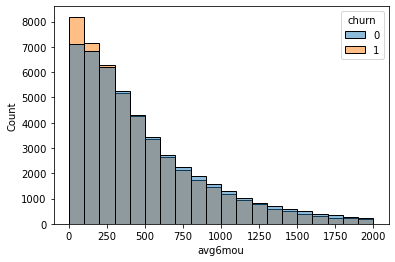

In [52]:
sns.histplot(data=df, x='avg6mou', hue='churn', binrange=(0, 2000), binwidth=100)

<AxesSubplot:xlabel='mou_cvce_Mean', ylabel='Count'>

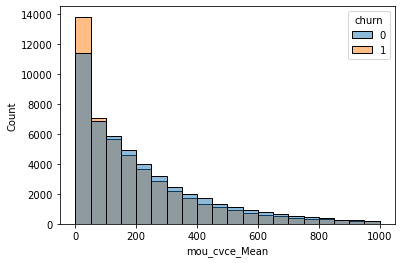

In [53]:
sns.histplot(data=df, x='mou_cvce_Mean', hue='churn', binrange=(0, 1000), binwidth=50)

<AxesSubplot:xlabel='attempt_Mean', ylabel='Count'>

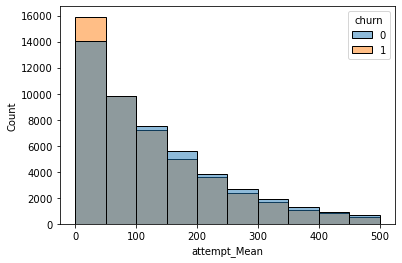

In [54]:
sns.histplot(data=df, x='attempt_Mean', hue='churn', binrange=(0, 500), binwidth=50)

<AxesSubplot:xlabel='complete_Mean', ylabel='Count'>

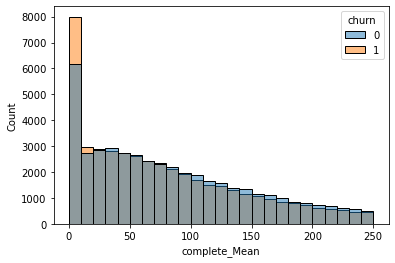

In [55]:
sns.histplot(data=df, x='complete_Mean', hue='churn', binrange=(0, 250), binwidth=10)

<AxesSubplot:xlabel='plcd_vce_Mean', ylabel='Count'>

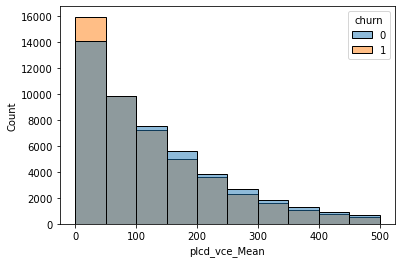

In [56]:
sns.histplot(data=df, x='plcd_vce_Mean', hue='churn', binrange=(0, 500), binwidth=50)

<AxesSubplot:xlabel='comp_vce_Mean', ylabel='Count'>

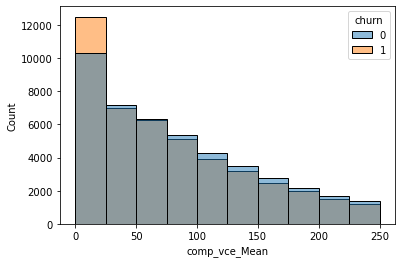

In [57]:
sns.histplot(data=df, x='comp_vce_Mean', hue='churn', binrange=(0, 250), binwidth=25)